# Quantum Binary Classifier using Parameterized Quantum Circuits (PQC)

This notebook implements a quantum binary classifier using Parameterized Quantum Circuits (PQC) with Qiskit.

## 1. Setup and Imports

In [10]:
# Import required libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler, Estimator

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Set random seeds
seed = 12345
algorithm_globals.random_seed = seed
np.random.seed(seed)

## 2. Data Preparation

In [ ]:
# Generate and prepare dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=seed)

# Scale features to be between 0 and pi
X_scaled = np.pi * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=seed
)

# Print feature ranges to verify scaling
print("Feature 1 range:", [X_scaled[:, 0].min(), X_scaled[:, 0].max()])
print("Feature 2 range:", [X_scaled[:, 1].min(), X_scaled[:, 1].max()])

num_features = X_train.shape[1]

Feature 1 range: [0.0, 6.283185307179585]
Feature 2 range: [0.0, 6.283185307179586]


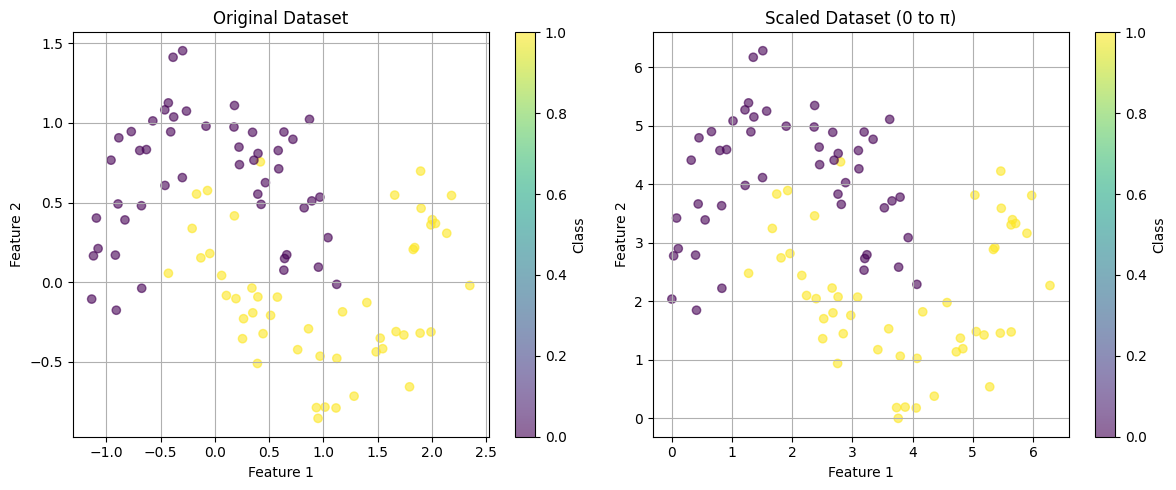

In [12]:
# Visualize the original and scaled datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original dataset
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
ax1.set_title('Original Dataset')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True)

# Plot scaled dataset
scatter2 = ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', alpha=0.6)
ax2.set_title('Scaled Dataset (0 to π)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.grid(True)

# Add colorbars
plt.colorbar(scatter1, ax=ax1, label='Class')
plt.colorbar(scatter2, ax=ax2, label='Class')

plt.tight_layout()
plt.show()

## 3. Quantum Circuit Components and Visualization

In [13]:
# Feature Map: Encodes classical data into quantum states
feature_map = ZZFeatureMap(
    feature_dimension=num_features,
    reps=1,  
    entanglement='full'  
)

# Ansatz: The trainable part of the PQC
ansatz = RealAmplitudes(
    num_qubits=num_features,
    reps=3,  
    entanglement='full',  
    insert_barriers=True
)

# Combine feature map and ansatz
pqc = QuantumCircuit(num_features)
pqc.compose(feature_map, inplace=True)
pqc.compose(ansatz, inplace=True)

### 3.1 Circuit Visualization
View the quantum circuits used in this classifier.

Plotting Feature Map...


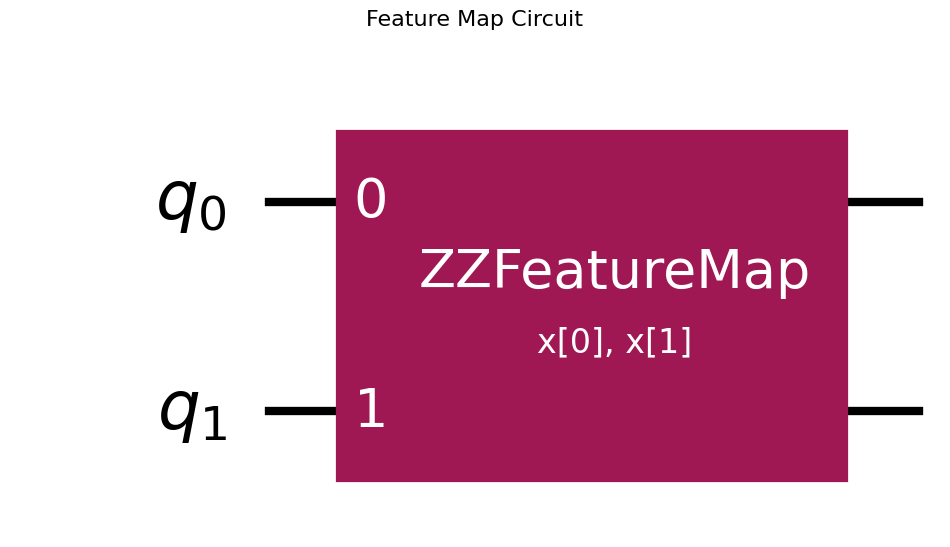

Plotting Ansatz...


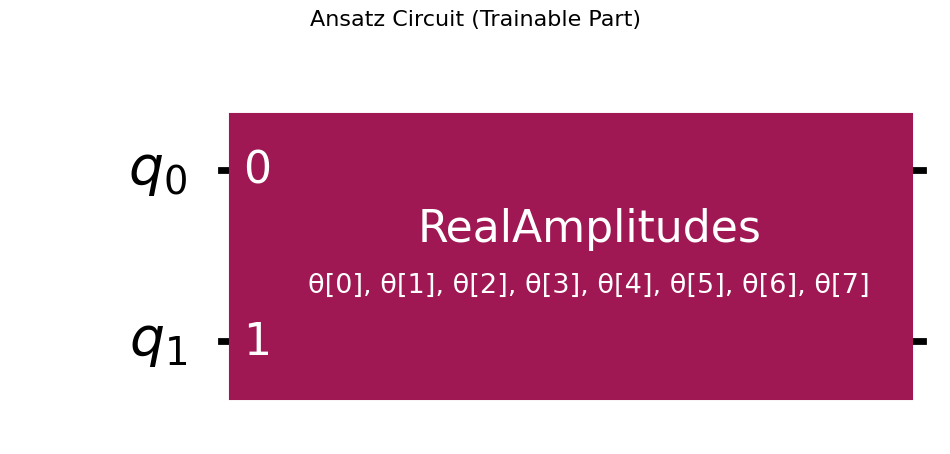

Plotting PQC...


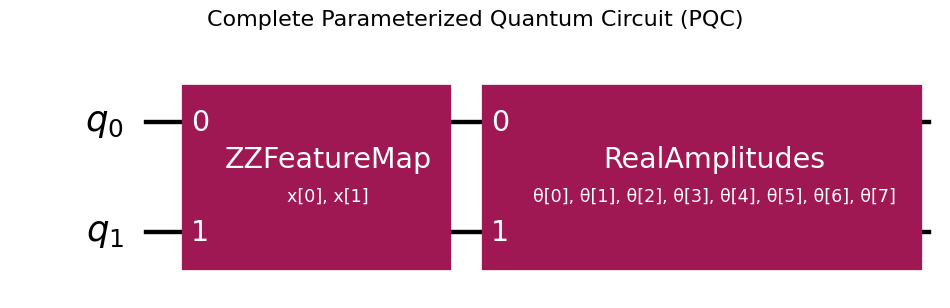

In [14]:
# Visualize the quantum circuits using matplotlib rendering
import matplotlib.pyplot as plt

# Configure matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

if 'feature_map' not in locals() or not isinstance(feature_map, QuantumCircuit):
    print("Warning: 'feature_map' is not defined as a QuantumCircuit. Skipping its plot.")
else:
    print("Plotting Feature Map...")
    # Draw circuit with explicit settings
    fig1, ax1 = plt.subplots()
    feature_map.draw('mpl', style='iqx', ax=ax1)
    ax1.set_title('Feature Map Circuit', fontsize=16)
    plt.close(fig1)  # Close the figure to prevent duplicate display
    display(fig1)  # Explicitly display the figure

if 'ansatz' not in locals() or not isinstance(ansatz, QuantumCircuit):
    print("Warning: 'ansatz' is not defined as a QuantumCircuit. Skipping its plot.")
else:
    print("Plotting Ansatz...")
    # Draw circuit with explicit settings
    fig2, ax2 = plt.subplots()
    ansatz.draw('mpl', style='iqx', ax=ax2)
    ax2.set_title('Ansatz Circuit (Trainable Part)', fontsize=16)
    plt.close(fig2)  # Close the figure to prevent duplicate display
    display(fig2)  # Explicitly display the figure

if 'pqc' not in locals() or not isinstance(pqc, QuantumCircuit):
    print("Warning: 'pqc' is not defined as a QuantumCircuit. Skipping its plot.")
else:
    print("Plotting PQC...")
    # Draw circuit with explicit settings
    fig3, ax3 = plt.subplots()
    pqc.draw('mpl', style='iqx', ax=ax3)
    ax3.set_title('Complete Parameterized Quantum Circuit (PQC)', fontsize=16)
    plt.close(fig3)  # Close the figure to prevent duplicate display
    display(fig3)  # Explicitly display the figure


## 4. Quantum Output and Cost Function

In [15]:
estimator = Estimator()

def get_quantum_output(data_point, parameters):
    """Executes the PQC and returns the expectation value of Z on the first qubit."""
    # Bind data to feature map parameters
    param_dict_fm = {fm_param: dp_val for fm_param, dp_val in zip(feature_map.parameters, data_point)}
    param_dict_ansatz = {ans_param: p_val for ans_param, p_val in zip(ansatz.parameters, parameters)}
    
    final_qc = pqc.assign_parameters({**param_dict_fm, **param_dict_ansatz})
    
    # Define the observable
    observable_str = "Z" + "I" * (num_features - 1)
    from qiskit.quantum_info import SparsePauliOp
    observable = SparsePauliOp(observable_str)
    
    # Calculate expectation value
    job = estimator.run([final_qc], [observable])
    result = job.result()
    expectation_value = result.values[0]
    
    return (expectation_value + 1) / 2.0

# Initialize list to store costs during training
costs = []

def cost_function(parameters):
    """Calculates the Mean Squared Error between predictions and true labels."""
    predictions = [get_quantum_output(x, parameters) for x in X_train]
    cost = np.mean((y_train - predictions) ** 2)
    costs.append(cost)  # Store the cost
    if len(costs) % 10 == 1:  # Print every 10th iteration
        print(f"Iteration {len(costs)-1}, Cost: {cost:.4f}")
    return cost

## 5. Training

Starting training...
Iteration 0, Cost: 0.3201
Iteration 10, Cost: 0.2639
Iteration 20, Cost: 0.2377
Iteration 30, Cost: 0.2375
Iteration 40, Cost: 0.2364
Iteration 50, Cost: 0.2364
Iteration 60, Cost: 0.2363
Iteration 70, Cost: 0.2363
Iteration 80, Cost: 0.2363
Iteration 90, Cost: 0.2363
Training complete.
Final cost: 0.2363


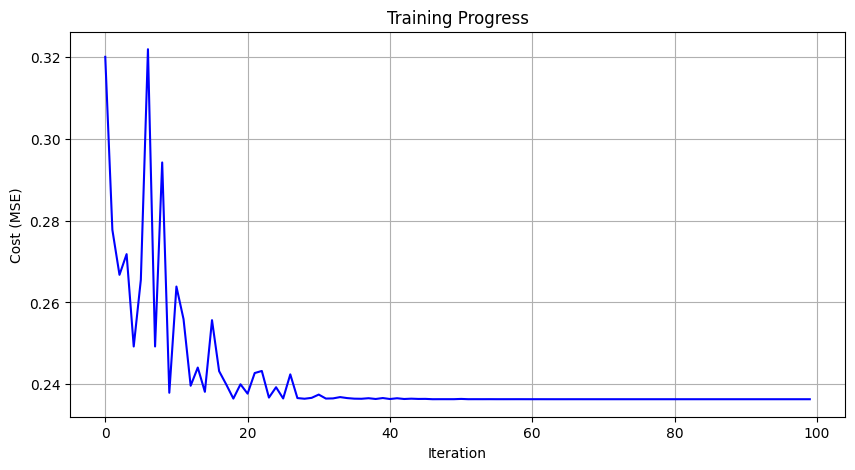


Optimized Parameters:
θ0: 2.282409
θ1: 1.446698
θ2: 0.066089
θ3: 1.349333
θ4: 0.482187
θ5: -0.001069
θ6: 1.134370
θ7: 0.246172


In [16]:
# Clear previous costs
costs = []

# Initialize and optimize
initial_parameters = np.random.random(ansatz.num_parameters)
optimizer = COBYLA(maxiter=100)

print("Starting training...")
opt_result = optimizer.minimize(fun=cost_function, x0=initial_parameters)

optimized_parameters = opt_result.x
print("Training complete.")
print(f"Final cost: {opt_result.fun:.4f}")

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(costs, 'b-')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Training Progress')
plt.grid(True)
plt.show()

# Print optimized parameters
print("\nOptimized Parameters:")
for i, param in enumerate(optimized_parameters):
    print(f"θ{i}: {param:.6f}")

## 6. Evaluation

Test Accuracy: 33.33%
Train Accuracy: 58.57%

F1 Score:
Test F1 Score: 0.4737
Train F1 Score: 0.5397


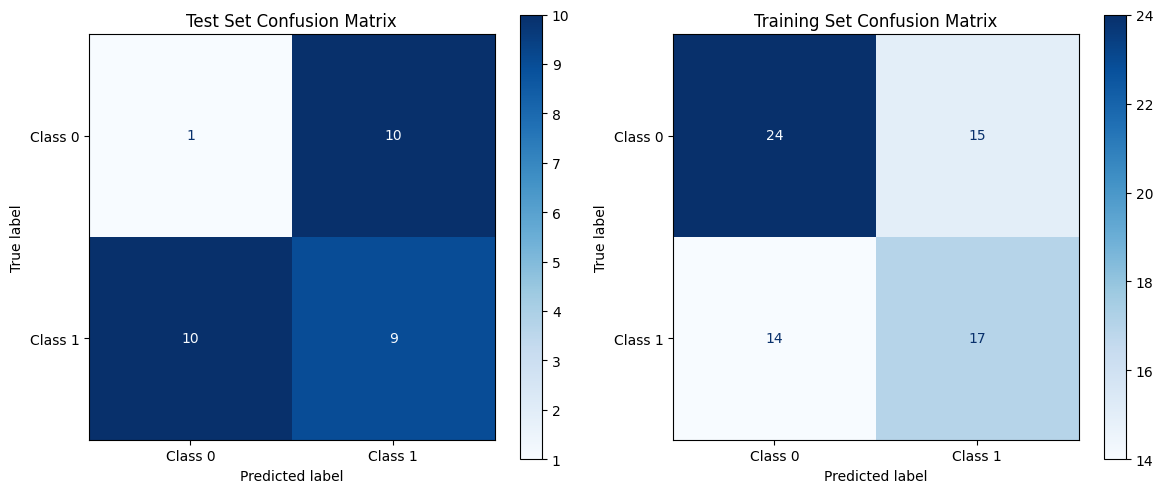


Confusion Matrix Analysis:
Test Set:
True Negatives: 1
False Positives: 10
False Negatives: 10
True Positives: 9

Training Set:
True Negatives: 24
False Positives: 15
False Negatives: 14
True Positives: 17


In [17]:
def predict(data, parameters):
    """Makes predictions for a given dataset using the trained parameters."""
    quantum_outputs = [get_quantum_output(x, parameters) for x in data]
    return (np.array(quantum_outputs) > 0.5).astype(int)

# Evaluate on test and training sets
y_pred_test = predict(X_test, optimized_parameters)
y_pred_train = predict(X_train, optimized_parameters)

# Calculate accuracies
accuracy = np.mean(y_pred_test == y_test)
train_accuracy = np.mean(y_pred_train == y_train)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Calculate metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Calculate F1 scores
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)

print(f"\nF1 Score:")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Train F1 Score: {f1_train:.4f}")

# Calculate confusion matrices
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot test set confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Class 0', 'Class 1'])
disp_test.plot(ax=ax1, cmap='Blues')
ax1.set_title('Test Set Confusion Matrix')

# Plot training set confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Class 0', 'Class 1'])
disp_train.plot(ax=ax2, cmap='Blues')
ax2.set_title('Training Set Confusion Matrix')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nConfusion Matrix Analysis:")
print("Test Set:")
print(f"True Negatives: {cm_test[0,0]}")
print(f"False Positives: {cm_test[0,1]}")
print(f"False Negatives: {cm_test[1,0]}")
print(f"True Positives: {cm_test[1,1]}")

print("\nTraining Set:")
print(f"True Negatives: {cm_train[0,0]}")
print(f"False Positives: {cm_train[0,1]}")
print(f"False Negatives: {cm_train[1,0]}")
print(f"True Positives: {cm_train[1,1]}")